## Objective of this notebook
To explore a dataset about credit card customer data and build **unsupervised learning models** to segment the customers. <br>
The results may help analyse customers' behaviours and/or characteristics of a group.

## Source of dataset
From Kaggle: [Credit Card Customer Data](https://www.kaggle.com/datasets/aryashah2k/credit-card-customer-data) <br>
Features are average credit limit, numbers of credit cards, bank visits, online visits and calls.

<h2> Exploratory Data Analysis </h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<p> <strong>Basic information</strong> of the dataset</p>

In [2]:
df = pd.read_csv('credit.csv')
print('Dataset shape:',df.shape)
print('Datatypes:', df.dtypes.unique())
print('With null values:',df.isnull().values.any())

Dataset shape: (660, 7)
Datatypes: [dtype('int64')]
With null values: False


In [3]:
df.head(3)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [5]:
df.drop(['Sl_No','Customer Key'], axis=1, inplace=True) #keep only useful features

In [6]:
df.astype('float64')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


**Avg Credit Limit** is understandably a key feature and high values are not treated as outliers.

## Feature Selection and Engineering

<AxesSubplot:>

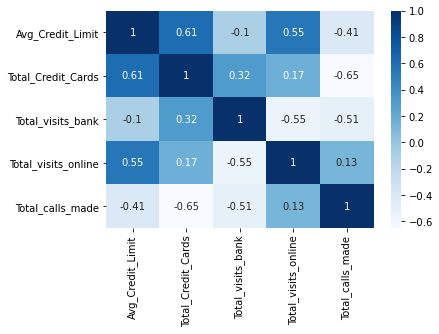

In [7]:
sns.heatmap(df.corr(), annot=True, cmap='Blues')

Some features are moderately correlated, customers who visit bank more often have less chance in making calls or online visits.  Customers who have more credit cards also tend to have higher average credit limits.

<h2> Model Training </h2>

Three models are selected to fit the data to serve different purposes.
1. **KMeans**
2. **Hierarchal Agglomerative Clustering (HAC)**
3. **DBSCAN**

DBSCAN is particularly used to find outliers in the dataset.

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering as HAC, DBSCAN
from sklearn.metrics import silhouette_score

First perform **MinMax scaling** to ensure all features share the same scale for calculating the distance.

In [9]:
mm = MinMaxScaler()
df_mm = mm.fit_transform(df)

### KMeans

A guess value of **k** could be determined by the **inertia and silhouette_score**.

In [10]:
def kmfit(X):
    k_range = np.arange(2,11)
    inertia = []
    sil_score = []

    for k in k_range:
        km = KMeans(n_clusters=k)
        km.fit(X)
        inertia.append(km.inertia_)
        sil_score.append(silhouette_score(X, km.labels_))
        
    return inertia, sil_score

In [11]:
inertia = []
sil_score = []
for k in range(2,11): #2 to 11 clusters
    km = KMeans(n_clusters=k)
    km.fit(df_mm)
    
    inertia.append(km.inertia_)
    sil_score.append(silhouette_score(df_mm, km.labels_))

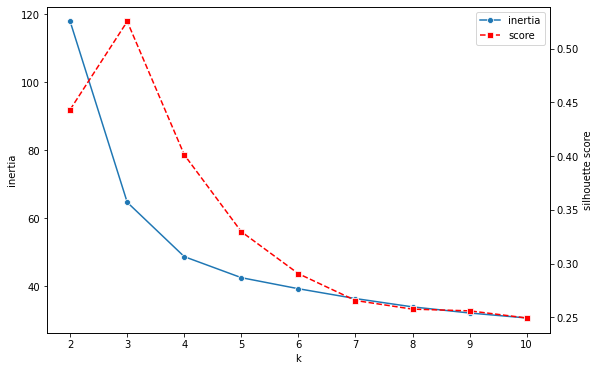

In [12]:
fig, ax = plt.subplots(figsize=(9,6))

ax2 = ax.twinx()

sns.lineplot(x=range(2,11), y=inertia, ax=ax, ls='-', marker='o', label='inertia')
sns.lineplot(x=range(2,11), y=sil_score, ax=ax2, ls='--', marker='s', color='red', label='score')
ax.set_xlabel('k')
ax.set_ylabel('inertia')
ax2.set_ylabel('silhouette score')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.get_legend().remove()
ax.legend(lines + lines2, labels + labels2, loc=0)

fig.show()

The above suggest **k = 3** is a fairly reasonable number of clusters.

In [14]:
km = KMeans(n_clusters=3)
km.fit(df_mm)
df['kmeans'] = km.labels_
    
df['kmeans'].value_counts()

0    385
1    225
2     50
Name: kmeans, dtype: int64

### HAC

HAC also yields similar numbers of data points within clusters.

In [15]:
hac = HAC(n_clusters=3, linkage='ward', compute_full_tree=True)
hac.fit(df_mm)
df['HAC'] = hac.labels_

df['HAC'].value_counts()

0    382
1    228
2     50
Name: HAC, dtype: int64

### DBSCAN

In [16]:
def dbscaneps(X, eps_0=0, delta=0.05):
    nlabels = [] 
    for i in range(1,101): #default 0 to 50
        db = DBSCAN(eps=eps_0 + i*delta, min_samples=5)
        db.fit(X)
        
        lbl, cnt = np.unique(db.labels_, return_counts=True)
        
        #count outlier numbers, zero if none
        cntout = dict(zip(lbl, cnt)).get(-1, 0)
        
        #report number of outliers or more than one clusters without outliers
        if (cntout > 0) | ((cntout == 0) & (len(lbl) > 1)):
            
            #minus 1 outlier class in the length of labels
            nlabels.append((eps_0 + i*delta, len(np.unique(db.labels_))-1, cntout))
            
    return nlabels

In [17]:
dfdb = dbscaneps(df_mm)

In [18]:
z = list(map(list, zip(*dfdb)))

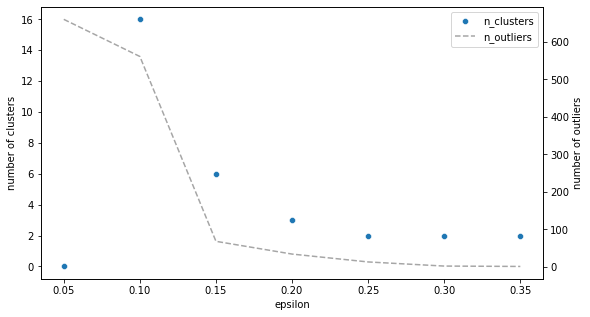

In [19]:
fig, ax = plt.subplots(figsize=(9,5))

ax2 = ax.twinx()

sns.scatterplot(x=z[0], y=z[1], ax=ax, label='n_clusters')
sns.lineplot(x=z[0], y=z[2], color='grey', alpha=0.7, ls='--', ax=ax2, label='n_outliers')

ax.set_xlabel('epsilon')
ax.set_ylabel('number of clusters')
ax2.set_ylabel('number of outliers')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.get_legend().remove()
ax.legend(lines + lines2, labels + labels2, loc=0)

fig.show()

Epsilon at 0.15 (6 clusters), 0.2 (3 clusters) and 0.35 (2 clusters) produce fairly low number of outliers. <br>
**epsilon = 0.15 or 0.2** produces rather **even-sized clusters**, where epsilon = 0.35 yields clusters of different magnitudes.

In [20]:
for eps in [0.15, 0.35, 0.2]:
    db = DBSCAN(eps=eps, min_samples=5)
    db.fit(df_mm)
    print(eps, np.unique(db.labels_, return_counts=True))

0.15 (array([-1,  0,  1,  2,  3,  4,  5], dtype=int64), array([ 68,  77, 154,  76,  95, 100,  90], dtype=int64))
0.35 (array([-1,  0,  1], dtype=int64), array([  1, 609,  50], dtype=int64))
0.2 (array([-1,  0,  1,  2], dtype=int64), array([ 34, 315, 290,  21], dtype=int64))


For comparison purpose, epsilon = 0.2 with 3 clusters are adopted.

In [21]:
df['DBSCAN'] = db.labels_

<h3> Model Evaluation </h3>

From the above models, it is observed that the data can be grouped into **3 clusters**. <br>
The labels for each algorithm are renamed as A/B/C according to the size of the clusters.  Outliers in DBSCAN is renamed as O.

In [22]:
dfn = df.copy()

In [23]:
dfn['kmeans'].replace({0:'B', 1:'C', 2:'A'}, inplace=True)
dfn['kmeans'].value_counts()

B    385
C    225
A     50
Name: kmeans, dtype: int64

In [24]:
dfn['HAC'].replace({0:'B', 1:'C', 2:'A'}, inplace=True)
dfn['HAC'].value_counts()

B    382
C    228
A     50
Name: HAC, dtype: int64

In [25]:
dfn['DBSCAN'].replace({0:'B', 1:'C', 2:'A',-1:'O'}, inplace=True) 
dfn['DBSCAN'].value_counts()

B    315
C    290
O     34
A     21
Name: DBSCAN, dtype: int64

A compare function is defined to check the agreement between algorithms.

In [26]:
def compare(algo1, algo2):
    print(df.groupby([algo1, algo2])[algo2].count())

The labels for KMeans and HAC agree to a large extent.

In [27]:
compare('kmeans','HAC')

kmeans  HAC
0       0      382
        1        3
1       1      225
2       2       50
Name: HAC, dtype: int64


The labels for HAC and DBSCAN switched.

In [28]:
compare('HAC','DBSCAN')

HAC  DBSCAN
0    -1          2
      0         90
      1        290
1    -1          3
      0        225
2    -1         29
      2         21
Name: DBSCAN, dtype: int64


A heatmap is to illustrate the comparison.  First further switch labels A and B in DBSCAN.

In [29]:
dfn['DBSCAN'].replace({'C':'B', 'B':'C'}, inplace=True) 

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
cm1 = confusion_matrix(dfn['kmeans'],dfn['HAC'])
cm2 = confusion_matrix(dfn['kmeans'],dfn['DBSCAN'])
cm3 = confusion_matrix(dfn['HAC'],dfn['DBSCAN'])

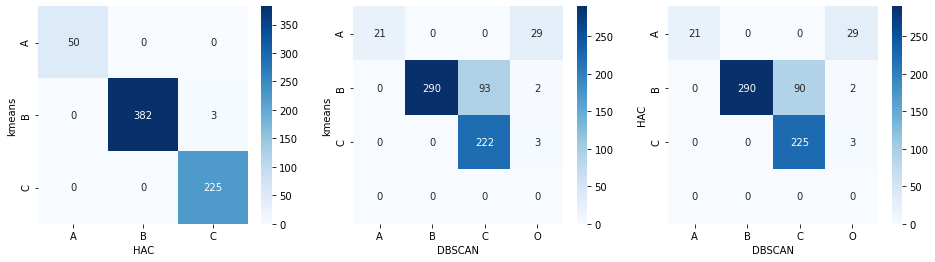

In [32]:
lbl1 = ['A', 'B', 'C']
lbl2 = ['A', 'B', 'C','O']

fig, ax = plt.subplots(1,3,figsize=(16,4))

sns.heatmap(cm1, annot=True, fmt='g', xticklabels=lbl1, yticklabels=lbl1, ax=ax[0], cmap='Blues')
sns.heatmap(cm2, annot=True, fmt='g', xticklabels=lbl2, yticklabels=lbl1, ax=ax[1], cmap='Blues')
sns.heatmap(cm3, annot=True, fmt='g', xticklabels=lbl2, yticklabels=lbl1, ax=ax[2], cmap='Blues')

ax[0].set_xlabel('HAC')
ax[0].set_ylabel('kmeans')
ax[1].set_xlabel('DBSCAN')
ax[1].set_ylabel('kmeans')
ax[2].set_xlabel('DBSCAN')
ax[2].set_ylabel('HAC')

fig.show()

It can be further seen that the 3 culsters A/B/C have rather **distinct mean value of features**. The **3 algorithms** have **converging results**.

In [33]:
pd.concat([dfn.groupby(['kmeans']).mean(), 
           dfn.groupby(['kmeans'])['kmeans'].count()], axis=1).rename(columns={'kmeans':'count'})

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count
kmeans,,,,,,
A,141040.000000,8.740000,0.600000,10.900000,1.080000,50
B,33792.207792,5.516883,3.496104,0.981818,1.994805,385
C,12253.333333,2.422222,0.933333,3.542222,6.857778,225


In [34]:
pd.concat([dfn.groupby(['HAC']).mean(), 
           dfn.groupby(['HAC'])['HAC'].count()], axis=1).rename(columns={'HAC':'count'})

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count
HAC,,,,,,
A,141040.000000,8.740000,0.600000,10.900000,1.080000,50
B,33960.732984,5.523560,3.507853,0.984293,1.979058,382
C,12254.385965,2.451754,0.947368,3.504386,6.820175,228


In [35]:
pd.concat([dfn.groupby(['DBSCAN']).mean(), 
           dfn.groupby(['DBSCAN'])['DBSCAN'].count()], axis=1).rename(columns={'DBSCAN':'count'})

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count
DBSCAN,,,,,,
A,147571.428571,9.095238,1.000000,10.190476,1.095238,21
B,32631.034483,5.513793,3.993103,1.017241,1.965517,290
C,19314.285714,3.342857,1.257143,2.739683,5.476190,315
O,122735.294118,7.735294,0.323529,10.235294,1.382353,34


The **3 groups** are, on average:

- A: small population high average credit limit (>\\$141,000), have more credit cards (8-9), more likely to make online visits
- B: middle population, mid average credit limit (\\$32,000 to \\$34,000), have some credit cards (5-6), more likely to visit banks
- C: middle population, low average credit limit (\\$12,000 to \\$20,000), have fewer credit cards (2-3), more likely to make calls

The outlier group found by DBSCAN resembles Group A, but have less average credit limit.

<h2> Summary </h2>

From the above analysis, 5 features of average credit limit, total number of credit cards, bank visits, online visits and calls made were used.  **KMeans, Hierarchal Agglomerative Clustering (HAC)**, and **DBSCAN** suggest segmenting the customers into **3 clusters**.

In respect of DBSCAN, with minimum number of sample of 5, the epsilon is reasonably set at 0.2 to obtain even-sized clusters.

The 3 **algorithms** generally **coverge** in segmenting the customers into the following 3 groups:  

- A: small population high average credit limit (>\\$141,000), have more credit cards (8-9), more likely to make online visits
- B: middle population, mid average credit limit (\\$32,000 to \\$34,000), have some credit cards (5-6), more likely to visit banks
- C: middle population, low average credit limit (\\$12,000 to \\$20,000), have fewer credit cards (2-3), more likely to make calls

The outlier group found by DBSCAN resembles Group A, but have less average credit limit.

### Possible Improvements
The authenticity of original dataset may be improved by **clarification of further suspected outliers**. <br>
**More features and observations** may be brough to the dataset for deeper analysis. <br>
A **finer scale of hyperparameters** may be deployed to refine the DBSCAN models.